In [1]:
import numpy as np
import cv2
import tensorflow as tf
import pandas as pd

In [2]:
import os
from tqdm.notebook import tqdm

In [3]:
from utils import helper_functions as hf
from utils import change_detection as cd
from utils import video_summarization_helper_functions as vshf
import Config as Config

In [4]:
test_directory = './videos/test videos/All Test Videos'

In [5]:
cols = ['file', 'type', 'f1', 'f2', 'f3', 'f4']

In [6]:
annotation_file = pd.read_csv('./test data/final_annotations.txt',sep=' ', header = None)

In [7]:
annotation_file = annotation_file.drop([1,3,5,7,9,11,12], axis=1)

In [8]:
annotation_file.columns=cols

In [9]:
annotation_file.head()

,file,type,f1,f2,f3,f4
0,Abuse028_x264.mp4,Abuse,165,240,-1,-1
1,Abuse030_x264.mp4,Abuse,1275,1360,-1,-1
2,Arrest001_x264.mp4,Arrest,1185,1485,-1,-1
3,Arrest007_x264.mp4,Arrest,1530,2160,-1,-1
4,Arrest024_x264.mp4,Arrest,1005,3105,-1,-1


In [10]:
files_in_directory = os.listdir(test_directory)

In [11]:
len(files_in_directory)

22

In [12]:
def get_keys_to_consider(significant_keys, frame_sequence_tracker):
    
    insignificant_keys = hf.get_insignificant_frame(significant_keys)

    # Loading the Fine Tuned Keras Model
    model = tf.keras.models.load_model(Config.FINE_TUNED_LSTM_AUTO_ENCODER_PATH)


    # Checking the prediction value of insignificant frame
    insig_cost_tracker = {}

    for key in insignificant_keys:
        insignificant_sequence = frame_sequence_tracker[insignificant_keys[0]]

        # Reshaping to get three 10-frame sequence batches for prediction
        reshaped_insignificant_sequences = insignificant_sequence.reshape(3, 10, 256, 256, 1)

        for index, single_sequence in enumerate(reshaped_insignificant_sequences):
            single_sequence = np.expand_dims(single_sequence, axis=0)
            reconstructed_sequence = model.predict(single_sequence)

            # Calculating reconstruction cost for the single sequence
            # cost = np.linalg.norm(single_sequence - reconstructed_sequence[0])
            cost = hf.get_reconstruction_cost(single_sequence, reconstructed_sequence)
            insig_cost_tracker[f'{key}_{index}'] = cost

    # Getting Max Insignificance prediction score
    max_insignificant_prediction_score = hf.get_max_from_cost_dict(insig_cost_tracker)

    # calculating anomaly threshold
    cut_off_threshold_percent = 4
    anomaly_threshold = hf.get_anomaly_threshold_from_normal_cost(max_insignificant_prediction_score, cut_off_threshold_percent)

    # Significant frames cost tracker
    cost_tracker = {}
    for key in significant_keys:
        significant_sequence = frame_sequence_tracker[key]
        reshaped_sequences = significant_sequence.reshape(3, 10, 256, 256, 1)
        for index, single_sequence in enumerate(reshaped_sequences):
            single_sequence = np.expand_dims(single_sequence, axis=0)
            reconstructed_sequence = model.predict(single_sequence)

            # Calculating reconstruction cost for the single sequence
            # cost = np.linalg.norm(single_sequence - reconstructed_sequence[0])
            cost = hf.get_reconstruction_cost(single_sequence, reconstructed_sequence)
            cost_tracker[f'{key}_{index}'] = cost

    # Defining keys to consider as a set to avoid duplicates
    keys_to_consider = set()

    # Logic to track all the prediction cost of significant frames
    cost_list = hf.get_values_from_dictionary(cost_tracker)

    # Calculating the prediction cost based on predicted cost list
    cost_threshold = hf.calculate_prediction_cost_threshold(cost_list)

    # Logic to extract frames with more reconstruction cost
    for index, cost in cost_tracker.items():
        if cost > anomaly_threshold:
            keys_to_consider.add(index)

    if len(keys_to_consider) == 0: #Fallback condition
        for index, cost in cost_tracker.items():
            if cost > cost_threshold:
                keys_to_consider.add(index)    
        
    return keys_to_consider
    

In [16]:
# Initializers for calculating metrics
true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0
total_frames_processed = 0

def handle_no_anomaly_cases(video_frames, f1_start, f1_end, f2_start, f2_end):
    tn, fn = 0, 0
    total_frames = len(video_frames)
    
    if f1_start == -1:  # No anomalies in ground truth
        tn += total_frames
    else:
        tn += f1_start
        fn += f1_end - f1_start + 1
        if f2_start != -1:
            tn += f2_start - f1_end - 1 #between anomalies
            fn += f2_end - f2_start + 1
            tn += total_frames - f2_end
        else:
            tn += total_frames - f1_end
    return tn, fn

for file in tqdm(files_in_directory):
    file_path = os.path.join(test_directory, file)
    file_name = os.path.basename(file_path) 
    
    if file_name.endswith('.mp4'):
        print(file_name)
        
        frames_to_evaluate = []
        
        row = annotation_file[annotation_file['file'] == file_name].iloc[0]
        f1_start, f1_end, f2_start, f2_end = row['f1'], row['f2'], row['f3'], row['f4']
        
        video_frames_dict = hf.get_frames_from_video(file_path)
        total_video_frames = len(video_frames_dict)
        # total_frames_processed += total_video_frames  # tracking totalframes processed 
        
        frames_in_batches = hf.get_frames_in_batches(30, video_frames_dict)
        frame_sequence_tracker = hf.get_frame_sequence_tracker(frames_in_batches)
        significant_keys = cd.perform_change_detection(frame_sequence_tracker)
        keys_to_consider = []
        
        if significant_keys:
            keys_to_consider = get_keys_to_consider(significant_keys, frame_sequence_tracker) 
            
            '''Appending change detection original frames for later evaluation '''
            for sig_key in significant_keys:
                start, end = hf.get_original_frame_numbers(sig_key, 30)
                for i in range(start, end + 1):
                    frames_to_evaluate.append(i)

        
        if not significant_keys or not keys_to_consider:
            message = 'No Anomaly Found: ' + ('Change Detection phase!!!' if not significant_keys else 'Anomaly Detector phase!!!')
            print(message)
            tn, fn = handle_no_anomaly_cases(video_frames_dict, f1_start, f1_end, f2_start, f2_end)
            true_negatives += tn
            false_negatives += fn
            total_frames_processed += len(video_frames_dict)
            continue
        
        frame_key_list = vshf.get_frame_key_list(keys_to_consider)
        original_frames_for_summarization = set()
        
        for key in frame_key_list:
            start, end = hf.get_original_frame_numbers(key, 30)
            original_frames_for_summarization.update(range(start, end + 1))
        
        for frame_number in frames_to_evaluate:  # Starting the frame count from 1
            total_frames_processed += 1
            if frame_number in original_frames_for_summarization:  # Detected as anomaly
                if (f1_start <= frame_number <= f1_end) or (f2_start != -1 and f2_start <= frame_number <= f2_end):
                    true_positives += 1
                else:
                    false_positives += 1
            else:  # Not detected as anomaly
                if (f1_start <= frame_number <= f1_end) or (f2_start != -1 and f2_start <= frame_number <= f2_end):
                    false_negatives += 1
                else:
                    true_negatives += 1

# Validate the metrics
assert total_frames_processed == (true_positives + false_positives + true_negatives + false_negatives), "Metrics don't add up!"


  0%|          | 0/22 [00:00<?, ?it/s]

Arrest001_x264.mp4
1/1 [==============================] - 0s 26ms/step
Fighting042_x264.mp4
1/1 [==============================] - 0s 26ms/step
Assault010_x264.mp4
1/1 [==============================] - 0s 30ms/step
Normal_Videos_003_x264.mp4
1/1 [==============================] - 0s 27ms/step
Arson007_x264.mp4
1/1 [==============================] - 0s 27ms/step
Normal_Videos_014_x264.mp4
1/1 [==============================] - 0s 26ms/step
Robbery102_x264.mp4
1/1 [==============================] - 0s 27ms/step
Explosion002_x264.mp4
1/1 [==============================] - 0s 28ms/step
Arson010_x264.mp4
1/1 [==============================] - 0s 29ms/step
Assault006_x264.mp4
1/1 [==============================] - 0s 27ms/step
Normal_Videos_024_x264.mp4
1/1 [==============================] - 0s 26ms/step
Abuse028_x264.mp4
1/1 [==============================] - 0s 26ms/step
Burglary024_x264.mp4
1/1 [==============================] - 0s 28ms/step
Assault011_x264.mp4
1/1 [=====================

In [17]:
print(f'Total Frames:{total_frames_processed},TP:{true_positives},TN:{true_negatives},FP:{false_positives},FN:{false_negatives}') 

Total Frames:15423,TP:4646,TN:5897,FP:3754,FN:1126


In [18]:
4646+5897+3754+1126


15423

In [19]:
total_frames_processed

15423

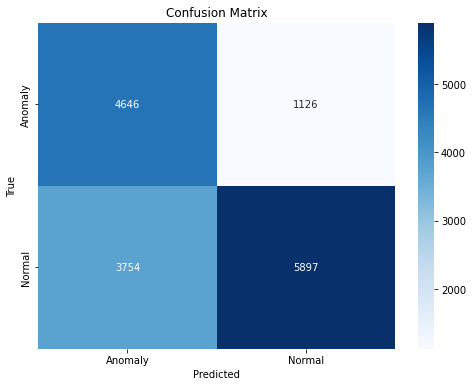

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define the labels for the classes
class_labels = ['Anomaly', 'Normal']

confusion_matrix = np.array([[true_positives, false_negatives],
                          [false_positives, true_negatives]])

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [21]:
accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
accuracy

0.6835894443363807

In [22]:
'''Sensitivity: How well the positive class was predicted'''

sensitivity = true_positives/(true_positives + false_negatives)
sensitivity

0.804920304920305

In [23]:
'''Specificity: How well the negative class was predicted'''

specificity = true_negatives / (true_negatives + false_positives)
specificity

0.6110247642731323

In [24]:
g_mean = np.sqrt(sensitivity * specificity)
g_mean

0.7013032436632438

In [25]:
precision = true_positives/(true_positives + false_positives)
precision

0.5530952380952381

In [26]:
recall = true_positives/(true_positives + false_negatives)
recall

0.804920304920305

In [27]:
f_score = (2 * precision * recall) / (precision + recall)
f_score

0.6556590460062094